# Utility Matrix Calculation

This notebook processes the `tomato irrigation dataset.csv` to create a "Utility Matrix".
The matrix represents the ideal environmental conditions (average of successful measurements) for each growth stage (`Crop Coefficient stage`).

**Update**: The `Crop Coefficient stage` is converted to numeric values:
- Initial Stage => 0
- Development Stage => 1
- Mid stage => 2
- Last stage => 3

In [33]:
import csv
import os
from collections import defaultdict

# Configuration
base_dir = r"C:\Users\marou\OneDrive\Desktop\Project"
input_file = "tomato irrigation dataset.csv"
output_file = "utility_matrix.csv"
# Using relative paths if the notebook is in the same folder, otherwise use absolute
if not os.path.exists(input_file):
    input_file = os.path.join(base_dir, "tomato irrigation dataset.csv")
    output_file = os.path.join(base_dir, "utility_matrix.csv")

# Mapping for Crop Coefficient stage
STAGE_MAPPING = {
    'Initial Stage': 0,
    'Development Stage': 1,
    'Mid stage': 2,
    'Last stage': 3
}

def create_utility_matrix(file_path, output_path):
    print(f"Loading data from {file_path}...")
    
    if not os.path.exists(file_path):
        print(f"Error: File not found at {file_path}")
        return

    # Columns we want to average
    target_columns = [
        'Temperature [_ C]', 'Humidity [%]', 'Soil moisture', 
        'Reference evapotranspiration', 'Evapotranspiration', 
        'Crop Coefficient', 'Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 
        'Potassium', 'Solar Radiation ghi', 'Wind Speed', 'pH'
    ]
    
    # Grouping column
    group_col = 'Crop Coefficient stage'

    # Data structures for aggregation
    sums = defaultdict(lambda: defaultdict(float))
    counts = defaultdict(lambda: defaultdict(int))
    
    headers = []
    
    try:
        with open(file_path, mode='r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            # Normalize headers (strip whitespace)
            original_fieldnames = reader.fieldnames
            if not original_fieldnames:
                print("Error: Empty CSV")
                return
                
            # Create a map of clean_name -> original_name
            header_map = {name.strip(): name for name in original_fieldnames}
            headers = list(header_map.keys())
            
            if group_col not in headers:
                print(f"Error: Grouping column '{group_col}' not found in {headers}")
                return
            
            available_cols = [c for c in target_columns if c in headers]
            print(f"Aggregating columns: {available_cols} based on mapped stages...")

            for row in reader:
                row_clean = {k.strip(): v for k, v in row.items()}
                
                # Get stage string
                stage_str = row_clean.get(group_col)
                if not stage_str or stage_str not in STAGE_MAPPING:
                    continue
                    
                # Map to numeric value
                stage = STAGE_MAPPING[stage_str]
                
                for col in available_cols:
                    val_str = row_clean.get(col, '').strip()
                    if val_str:
                        try:
                            val = float(val_str)
                            sums[stage][col] += val
                            counts[stage][col] += 1
                        except ValueError:
                            pass 
                            
    except Exception as e:
        print(f"Error processing CSV: {e}")
        return

    # Calculate means
    # Stages are now 0, 1, 2, 3 so sorting works numerically
    stages = sorted(sums.keys())
    output_rows = []
    
    for stage in stages:
        row_data = {group_col: stage}
        for col in available_cols:
            count = counts[stage][col]
            if count > 0:
                avg = sums[stage][col] / count
                row_data[col] = round(avg, 2)
            else:
                row_data[col] = ''
        output_rows.append(row_data)
        
    # Write output
    output_headers = [group_col] + available_cols
    
    try:
        with open(output_path, mode='w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=output_headers)
            writer.writeheader()
            writer.writerows(output_rows)
        print(f"Utility matrix successfully saved to {output_path}")
        
        print("\nMatrix Preview (Stages 0-3):")
        print(f"{group_col:<25} | " + " | ".join(available_cols[:3]) + " ...")
        print("-" * 80)
        for r in output_rows[:5]:
            vals = [str(r.get(c, '')) for c in available_cols[:3]]
            print(f"{r[group_col]:<25} | " + " | ".join(vals) + " ...")
            
    except Exception as e:
        print(f"Error writing output: {e}")

# Run the function
create_utility_matrix(input_file, output_file)

Loading data from tomato irrigation dataset.csv...
Aggregating columns: ['Temperature [_ C]', 'Humidity [%]', 'Soil moisture', 'Reference evapotranspiration', 'Evapotranspiration', 'Crop Coefficient', 'Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 'Potassium', 'Solar Radiation ghi', 'Wind Speed', 'pH'] based on mapped stages...
Utility matrix successfully saved to utility_matrix.csv

Matrix Preview (Stages 0-3):
Crop Coefficient stage    | Temperature [_ C] | Humidity [%] | Soil moisture ...
--------------------------------------------------------------------------------
0                         | 28.64 | 81.23 | 285.24 ...
1                         | 27.87 | 83.16 | 275.49 ...
2                         | 25.05 | 77.07 | 406.11 ...
3                         | 25.31 | 77.56 | 401.49 ...


# Correlation Matrix

Generates a heatmap of correlations between variables.
Now includes `Crop Coefficient stage` as a numeric variable (0-3).

In [34]:
# Dependencies Installation
!pip install pandas seaborn matplotlib numpy

Generating Correlation Matrix from: tomato irrigation dataset.csv

Correlation Matrix Calculated:
                              Crop Coefficient stage  Temperature [_ C]  \
Crop Coefficient stage                      1.000000          -0.205374   
Temperature [_ C]                          -0.205374           1.000000   
Humidity [%]                               -0.113871           0.023744   
Soil moisture                               0.184389          -0.074108   
Reference evapotranspiration                0.223206          -0.041867   

                              Humidity [%]  Soil moisture  \
Crop Coefficient stage           -0.113871       0.184389   
Temperature [_ C]                 0.023744      -0.074108   
Humidity [%]                      1.000000      -0.063626   
Soil moisture                    -0.063626       1.000000   
Reference evapotranspiration     -0.059382       0.100081   

                              Reference evapotranspiration  \
Crop Coefficient stage

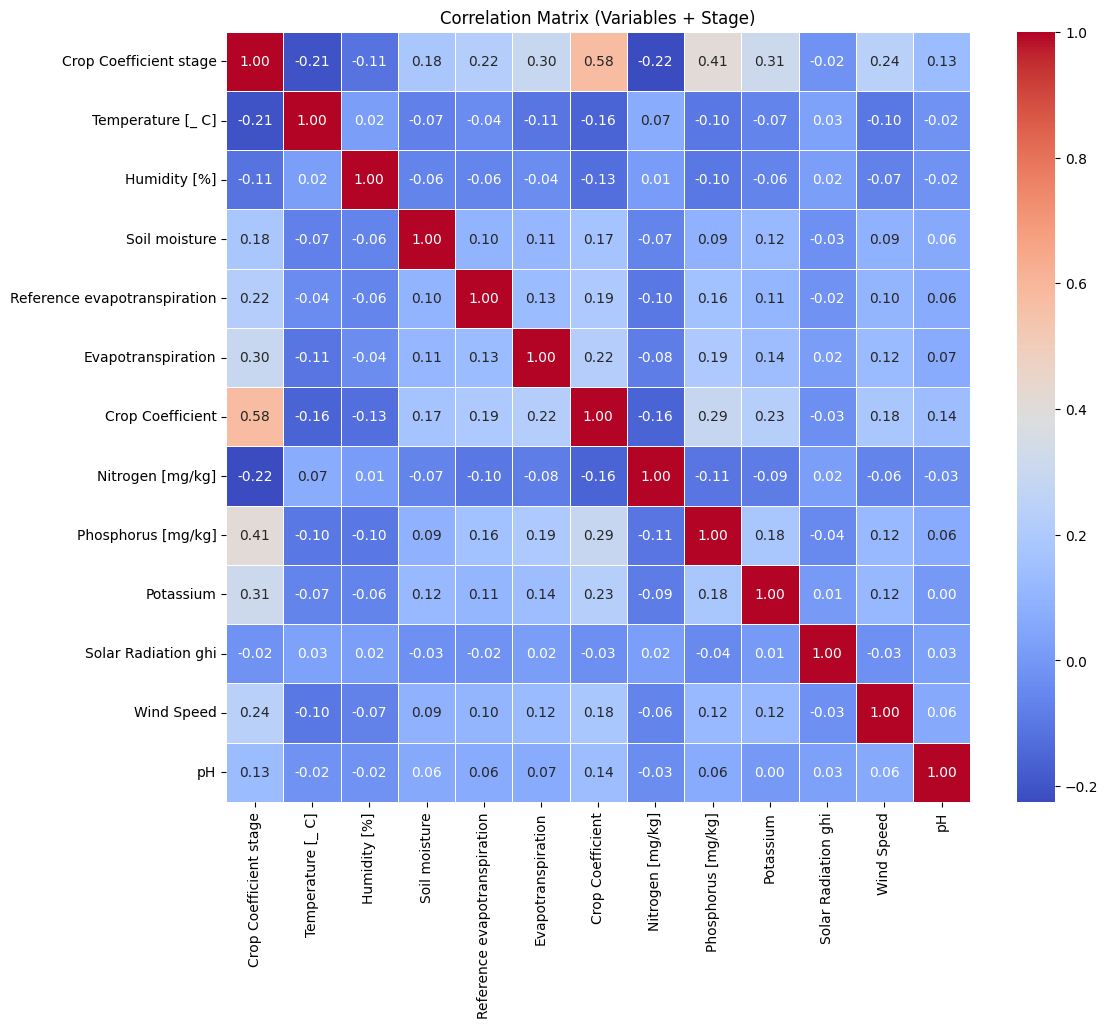

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Configuration
input_file = "tomato irrigation dataset.csv"
base_dir = r"C:\Users\marou\OneDrive\Desktop\Project"
if not os.path.exists(input_file):
    input_file = os.path.join(base_dir, "tomato irrigation dataset.csv")

# Mapping for Crop Coefficient stage
STAGE_MAPPING = {
    'Initial Stage': 0,
    'Development Stage': 1,
    'Mid stage': 2,
    'Last stage': 3
}

print(f"Generating Correlation Matrix from: {input_file}")

try:
    df = pd.read_csv(input_file)
    df.columns = df.columns.str.strip()
    
    # Apply mapping to convert Stage to Numeric
    if 'Crop Coefficient stage' in df.columns:
        df['Crop Coefficient stage'] = df['Crop Coefficient stage'].map(STAGE_MAPPING)
    
    # Select Numerical Columns (Including the mapped 'Crop Coefficient stage' if desired)
    numerical_cols = [
        'Crop Coefficient stage',
        'Temperature [_ C]', 'Humidity [%]', 'Soil moisture', 
        'Reference evapotranspiration', 'Evapotranspiration', 
        'Crop Coefficient', 'Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 
        'Potassium', 'Solar Radiation ghi', 'Wind Speed', 'pH'
    ]
    
    existing_cols = [c for c in numerical_cols if c in df.columns]
    df_num = df[existing_cols]
    
    if df_num.empty:
        print("Error: No numerical columns found to correlate.")
    else:
        corr_matrix = df_num.corr()
        
        print("\nCorrelation Matrix Calculated:")
        print(corr_matrix.head())
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title("Correlation Matrix (Variables + Stage)")
        plt.show()
        
except Exception as e:
    print(f"An error occurred: {e}")

# Similarity Matrix

Calculates Similarity between the **Growth Stages** (0, 1, 2, 3).

**Note:** Using custom calculation to avoid 'scikit-learn' dependency issues.

Generating Similarity Matrix from: utility_matrix.csv

Similarity Matrix:
Crop Coefficient stage         0         1         2         3
Crop Coefficient stage                                        
0                       1.000000  0.939699  0.931455  0.939468
1                       0.939699  1.000000  0.818014  0.836630
2                       0.931455  0.818014  1.000000  0.999395
3                       0.939468  0.836630  0.999395  1.000000


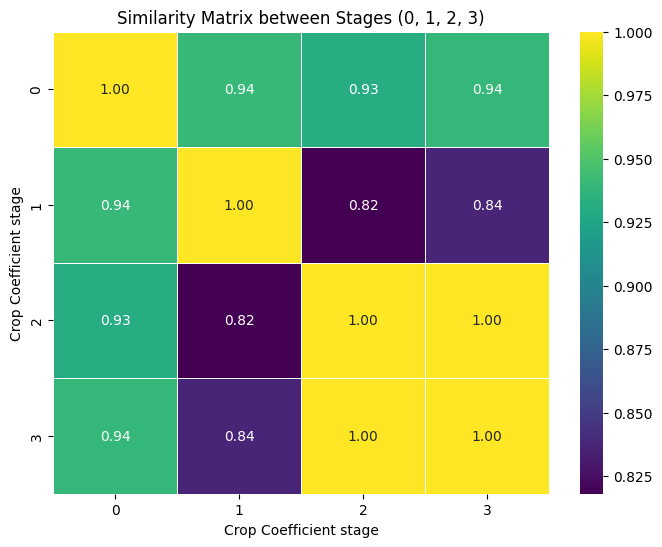

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

def calculate_cosine_similarity(df):
    """
    Calculates cosine similarity matrix for a given DataFrame (rows are items to compare)
    using only numpy/pandas (avoiding sklearn if it's broken).
    """
    # 1. Convert to numpy array
    data = df.values
    
    # 2. Normalize each row (L2 norm)
    # norm = sqrt(sum(x^2))
    norm = np.linalg.norm(data, axis=1)
    
    # Avoid division by zero
    norm[norm == 0] = 1e-10
    
    # 3. Divide data by norm to get unit vectors
    # [:, np.newaxis] ensures we divide column-wise correctly
    normalized_data = data / norm[:, np.newaxis]
    
    # 4. Dot product of normalized data gives cosine similarity
    # (A/|A|) . (B/|B|) = cos(theta)
    similarity_matrix = np.dot(normalized_data, normalized_data.T)
    
    return similarity_matrix

utility_file = "utility_matrix.csv"
base_dir = r"C:\Users\marou\OneDrive\Desktop\Project"
if not os.path.exists(utility_file):
    utility_file = os.path.join(base_dir, "utility_matrix.csv")

print(f"Generating Similarity Matrix from: {utility_file}")

try:
    df_utility = pd.read_csv(utility_file, index_col='Crop Coefficient stage')
    
    # Select numeric columns for calculation
    df_numeric = df_utility.select_dtypes(include=['float64', 'int64'])
    
    if df_numeric.empty:
        print("Error: Utility matrix has no numeric data.")
    else:
        # Use our custom function instead of sklearn
        similarity_matrix = calculate_cosine_similarity(df_numeric)
        
        # The index (stages) should be 0, 1, 2, 3
        similarity_df = pd.DataFrame(
            similarity_matrix,
            index=df_numeric.index,
            columns=df_numeric.index
        )
        
        print("\nSimilarity Matrix:")
        print(similarity_df)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(similarity_df, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
        plt.title("Similarity Matrix between Stages (0, 1, 2, 3)")
        plt.show()
        
except Exception as e:
    print(f"An error occurred: {e}")

# Negative Sampling (Data Augmentation)

To build a robust recommendation system, we need examples of "Good" conditions (Positive) and "Bad" conditions (Negative).
The original dataset provides "Positive" samples (Target=1).
We will generate "Negative" samples (Target=0) by adding random noise to create unsuitable conditions.

**Note:** Augmented to perturb more environmental factors.

In [37]:
import pandas as pd
import numpy as np
import os

input_file = "tomato irrigation dataset.csv"
base_dir = r"C:\Users\marou\OneDrive\Desktop\Project"
if not os.path.exists(input_file):
    input_file = os.path.join(base_dir, "tomato irrigation dataset.csv")

# Output for augmented data
augmented_output_file = "augmented_dataset.csv"
if not os.path.exists(augmented_output_file):
     augmented_output_file = os.path.join(base_dir, "augmented_dataset.csv")

STAGE_MAPPING = {
    'Initial Stage': 0,
    'Development Stage': 1,
    'Mid stage': 2,
    'Last stage': 3
}

print(f"Loading original data for augmentation from: {input_file}")

try:
    # 1. Load Positive Samples (Original Data)
    df_positive = pd.read_csv(input_file)
    df_positive.columns = df_positive.columns.str.strip()
    
    # Map Stages to Numeric
    if 'Crop Coefficient stage' in df_positive.columns:
        df_positive['Crop Coefficient stage'] = df_positive['Crop Coefficient stage'].map(STAGE_MAPPING)
        
    # Drop rows without stage mapping if any match failed
    df_positive = df_positive.dropna(subset=['Crop Coefficient stage'])
    
    # Assign Target = 1 (Positive/Good Choice)
    df_positive['Target'] = 1
    
    print(f"Positive Samples: {len(df_positive)}")
    
    # 2. Generate Negative Samples
    # We create a copy and perturb values to essentially 'ruin' the conditions
    df_negative = df_positive.copy()
    
    # Parameters to perturb (Environmental factors)
    # Added more columns as requested
    perturb_cols = [
        'Temperature [_ C]', 'Humidity [%]', 'Soil moisture', 
        'Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 'Potassium', 
        'pH', 'Solar Radiation ghi', 'Wind Speed'
    ]
    
    # Add random noise. We assume large deviation = bad.
    # We add Gaussian noise with mean 0 and high variance.
    np.random.seed(42)
    
    for col in perturb_cols:
        if col in df_negative.columns:
            # std deviation of the column
            sigma = df_negative[col].std()
            # Add noise: random value between +/- (2 * sigma) to ensure it's different enough
            noise = np.random.uniform(low=-3*sigma, high=3*sigma, size=len(df_negative))
            df_negative[col] = df_negative[col] + noise
            
            # Ensure no physical impossibilities
            if 'Humidity' in col or 'moisture' in col:
                df_negative[col] = df_negative[col].clip(lower=0, upper=100)
            elif 'Temperature' in col:
                df_negative[col] = df_negative[col].clip(lower=-10, upper=60)
            elif 'pH' in col:
                df_negative[col] = df_negative[col].clip(lower=0, upper=14)
            elif 'Speed' in col or 'Radiation' in col:
                df_negative[col] = df_negative[col].clip(lower=0)

    # Assign Target = 0 (Negative/Bad Choice)
    df_negative['Target'] = 0
    
    print(f"Negative Samples Generated: {len(df_negative)}")
    
    # 3. Combine Datasets
    df_augmented = pd.concat([df_positive, df_negative], ignore_index=True)
    
    # Shuffle the dataset
    df_augmented = df_augmented.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"Total Augmented Data Size: {len(df_augmented)}")
    print("\nAugmented Data Preview (First 5 rows):")
    print(df_augmented[['Crop Coefficient stage', 'Temperature [_ C]', 'Target']].head())
    
    # 4. Save
    df_augmented.to_csv(augmented_output_file, index=False)
    print(f"\nAugmented dataset saved to: {augmented_output_file}")
    
except Exception as e:
    print(f"An error occurred during augmentation: {e}")

Loading original data for augmentation from: tomato irrigation dataset.csv
Positive Samples: 3000
Negative Samples Generated: 3000
Total Augmented Data Size: 6000

Augmented Data Preview (First 5 rows):
   Crop Coefficient stage  Temperature [_ C]  Target
0                       2          28.790000       1
1                       2          42.612644       0
2                       1          28.900000       1
3                       2          20.040000       1
4                       2           8.276606       0

Augmented dataset saved to: augmented_dataset.csv


# Recommendation & Prediction System

This section builds a comprehensive system that:
1. **Predicts Suitability**: Uses a ML model trained on the augmented data to predict if current conditions are "Suitable" (Good/1) or "Unsuitable" (Bad/0).
2. **Recommends Actions**: If conditions are unsuitable, compares them against the **Utility Matrix** (Ideal Needs) and recommends specific adjustements.

**Note**: Implemented using **Combined KNN (Numpy)** to ensure reliability even without scikit-learn.

In [38]:
import pandas as pd
import numpy as np
import os

# --- CUSTOM CLASSIFIER (To replace broken sklearn) ---
class SimpleKNNClassifier:
    """
    Simple K-Nearest Neighbors classifier implemented using Numpy.
    Used to bypass dependency issues with scikit-learn.
    """
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.min_vals = None
        self.max_vals = None
    
    def fit(self, X, y):
        # Store data as numpy arrays
        X_arr = np.array(X, dtype=float)
        self.y_train = np.array(y, dtype=int)
        
        # Simple Min-Max Scaling to ensure all features contribute equally
        self.min_vals = X_arr.min(axis=0)
        self.max_vals = X_arr.max(axis=0)
        # Avoid division by zero
        self.max_vals[self.max_vals == self.min_vals] = self.min_vals[self.max_vals == self.min_vals] + 1.0
        
        self.X_train = (X_arr - self.min_vals) / (self.max_vals - self.min_vals)
        
    def predict_one(self, x_row):
        # Scale input
        x_scaled = (x_row - self.min_vals) / (self.max_vals - self.min_vals)
        
        # Calculate Euclidean distance to all training points
        # dist = sqrt(sum((x - x_train)^2))
        dists = np.sqrt(np.sum((self.X_train - x_scaled)**2, axis=1))
        
        # Find k nearest indices
        k_indices = np.argsort(dists)[:self.k]
        
        # Vote
        k_labels = self.y_train[k_indices]
        # If sum of 1s > k/2, then predict 1
        prediction = 1 if np.sum(k_labels) > (self.k / 2) else 0
        
        # Simple confidence (percentage of vote)
        proba = np.sum(k_labels) / self.k
        
        return prediction, proba

    def predict(self, X):
        X_arr = np.array(X, dtype=float)
        preds = []
        for row in X_arr:
            p, _ = self.predict_one(row)
            preds.append(p)
        return np.array(preds)

# 1. configuration
augmented_file = "augmented_dataset.csv"
utility_file = "utility_matrix.csv"
base_dir = r"C:\Users\marou\OneDrive\Desktop\Project"
if not os.path.exists(augmented_file):
     augmented_file = os.path.join(base_dir, "augmented_dataset.csv")
if not os.path.exists(utility_file):
     utility_file = os.path.join(base_dir, "utility_matrix.csv")

print("Initializing Prediction & Recommendation System (Using Custom KNN Model)...")

try:
    # --- Part A: Train Prediction Model ---
    df = pd.read_csv(augmented_file)
    
    # COMPLETE FEATURE LIST (All environmental variables)
    feature_cols = [
        'Crop Coefficient stage', 
        'Temperature [_ C]', 'Humidity [%]', 'Soil moisture', 
        'Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 'Potassium',
        'pH', 'Solar Radiation ghi', 'Wind Speed'
    ]
    
    # Filter features that actually exist
    features = [c for c in feature_cols if c in df.columns]
    print(f"Training with features: {features}")
    target = 'Target'
    
    X = df[features]
    y = df[target]
    
    # Custom Split (Shuffle and split 80/20)
    indices = np.random.permutation(len(df))
    split_idx = int(len(df) * 0.8)
    train_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    # Train Custom KNN
    clf = SimpleKNNClassifier(k=5)
    clf.fit(X_train, y_train)
    
    # Evaluate
    eval_preds = clf.predict(X_test)
    accuracy = np.mean(eval_preds == y_test)
    print(f"Prediction Model Trained. Accuracy: {accuracy*100:.2f}%")
    
    # --- Part B: Load Utility Matrix for Recommendations ---
    df_utility = pd.read_csv(utility_file)
    if 'Crop Coefficient stage' in df_utility.columns:
        df_utility.set_index('Crop Coefficient stage', inplace=True)

    # --- Part C: Recommendation Function ---
    def get_recommendation(current_conditions):
        """
        Input: dict of current conditions (must include 'Crop Coefficient stage')
        Output: Prediction (Good/Bad) + Recommendation Text
        """
        # 1. Prepare Input for Prediction
        # Convert dict to array of values in correct order
        values = []
        for col in features:
            values.append(current_conditions.get(col, 0.0))
        
        # Predict using custom model
        input_arr = np.array(values)
        prediction, prob = clf.predict_one(input_arr)
        
        status = "SUITABLE" if prediction == 1 else "UNSUITABLE"
        
        report = f"*** Analysis Report ***\n"
        report += f"Prediction: {status} (Confidence: {100*prob if prediction==1 else 100*(1-prob):.1f}%)\n"
        
        # 2. Generate Recommendations (Rule-based correction using Utility Matrix)
        stage = current_conditions.get('Crop Coefficient stage')
        
        if stage is not None and stage in df_utility.index:
            ideals = df_utility.loc[stage]
            recs = []
            
            # Check key variables (Now checking more cols including pH)
            check_vars = ['Temperature [_ C]', 'Humidity [%]', 'Soil moisture', 'pH', 'Potassium', 'Nitrogen [mg/kg]']
            
            for var in check_vars:
                if var in current_conditions and var in ideals:
                    current = current_conditions[var]
                    ideal = ideals[var]
                    
                    # Threshold for recommendation
                    diff = ideal - current
                    if abs(diff) > (ideal * 0.1): # 10% tolerance
                        if diff > 0:
                            recs.append(f"- INCREASE {var} by {diff:.2f} (Ideal: {ideal:.2f})")
                        else:
                            recs.append(f"- DECREASE {var} by {abs(diff):.2f} (Ideal: {ideal:.2f})")
                            
            if recs:
                report += "\nRecommendations to optimize plant needs:\n"
                report += "\n".join(recs)
            else:
                if prediction == 1:
                    report += "\nConditions are within optimal range. No changes needed."
                else:
                    report += "\nCheck other minor factors (NPK levels etc)."
        else:
            report += "\n(Cannot retrieve ideals: Stage not found in Utility Matrix)"
            
        return report

    # --- Part D: Demo ---
    print("\n--- DEMO Simulation ---")
    
    # Scenario 1: Optimized conditions (from Utility Matrix Stage 1)
    print("\nScenario 1: Testing with Ideal Conditions (Stage 1)")
    # Fetch ideal values directly to test
    ideal_stage_1 = df_utility.loc[1].to_dict()
    ideal_stage_1['Crop Coefficient stage'] = 1
    # Filter to only relevant keys for cleanliness
    test_input_1 = {k: v for k, v in ideal_stage_1.items() if k in features}
    print(get_recommendation(test_input_1))
    
    # Scenario 2: Bad conditions (High Temp, Low Humidity, Bad pH)
    print("\nScenario 2: Testing with Bad Conditions (Stage 1)")
    test_input_2 = test_input_1.copy()
    test_input_2['Temperature [_ C]'] += 20 
    test_input_2['Humidity [%]'] -= 30      
    test_input_2['pH'] += 3 # Too alkaline
    
    print(get_recommendation(test_input_2))
    
except Exception as e:
    print(f"An error occurred: {e}")

Initializing Prediction & Recommendation System (Using Custom KNN Model)...
Training with features: ['Crop Coefficient stage', 'Temperature [_ C]', 'Humidity [%]', 'Soil moisture', 'Nitrogen [mg/kg]', 'Phosphorus [mg/kg]', 'Potassium', 'pH', 'Solar Radiation ghi', 'Wind Speed']
Prediction Model Trained. Accuracy: 95.58%

--- DEMO Simulation ---

Scenario 1: Testing with Ideal Conditions (Stage 1)
*** Analysis Report ***
Prediction: SUITABLE (Confidence: 100.0%)

Conditions are within optimal range. No changes needed.

Scenario 2: Testing with Bad Conditions (Stage 1)
*** Analysis Report ***
Prediction: UNSUITABLE (Confidence: 100.0%)

Recommendations to optimize plant needs:
- DECREASE Temperature [_ C] by 20.00 (Ideal: 27.87)
- INCREASE Humidity [%] by 30.00 (Ideal: 83.16)
- DECREASE pH by 3.00 (Ideal: 4.11)


# User Testing Scenarios
Testing the system with 5 diverse examples.

In [39]:
# 5 Test Scenarios covering different Stages and Conditions

test_scenarios = [
    # 1. Ideal Case (Initial Stage 0)
    {
        'Name': "Case 1: Perfect Initial Stage",
        'Data': {
            'Crop Coefficient stage': 0,
            'Temperature [_ C]': 25.0, # Good
            'Humidity [%]': 70.0,      # Good
            'Soil moisture': 60.0,
            'Nitrogen [mg/kg]': 150,
            'Phosphorus [mg/kg]': 80,
            'Potassium': 200,
            'pH': 6.5,                # Ideal
            'Solar Radiation ghi': 500,
            'Wind Speed': 2.0
        }
    },
    # 2. Hot & Dry (Development Stage 1)
    {
        'Name': "Case 2: Hot and Dry (Stress)",
        'Data': {
            'Crop Coefficient stage': 1,
            'Temperature [_ C]': 40.0, # Too Hot
            'Humidity [%]': 30.0,      # Too Dry
            'Soil moisture': 20.0,     # Too Dry
            'Nitrogen [mg/kg]': 140,
            'Phosphorus [mg/kg]': 75,
            'Potassium': 190,
            'pH': 6.2,
            'Solar Radiation ghi': 800,
            'Wind Speed': 5.0
        }
    },
    # 3. Nutrient Deficiency (Mid Stage 2)
    {
        'Name': "Case 3: Nutrient Deficiency",
        'Data': {
            'Crop Coefficient stage': 2,
            'Temperature [_ C]': 28.0,
            'Humidity [%]': 65.0,
            'Soil moisture': 70.0,
            'Nitrogen [mg/kg]': 50,    # Very Low
            'Phosphorus [mg/kg]': 20,  # Low
            'Potassium': 100,          # Low
            'pH': 6.5,
            'Solar Radiation ghi': 600,
            'Wind Speed': 3.0
        }
    },
    # 4. Acidic & Windy (Last Stage 3)
    {
        'Name': "Case 4: Acidic Soil & High Wind",
        'Data': {
            'Crop Coefficient stage': 3,
            'Temperature [_ C]': 26.0,
            'Humidity [%]': 60.0,
            'Soil moisture': 55.0,
            'Nitrogen [mg/kg]': 140,
            'Phosphorus [mg/kg]': 80,
            'Potassium': 210,
            'pH': 4.0,                 # Too Acidic
            'Solar Radiation ghi': 550,
            'Wind Speed': 15.0         # High Wind
        }
    },
    # 5. Over-watering (Development Stage 1)
    {
        'Name': "Case 5: Over-watering Risk",
        'Data': {
            'Crop Coefficient stage': 1,
            'Temperature [_ C]': 22.0,
            'Humidity [%]': 95.0,      # Too Humid
            'Soil moisture': 98.0,     # Saturated
            'Nitrogen [mg/kg]': 130,
            'Phosphorus [mg/kg]': 70,
            'Potassium': 180,
            'pH': 6.8,
            'Solar Radiation ghi': 300,
            'Wind Speed': 1.0
        }
    }
]

print("Running 5 Test Scenarios...\n" + "="*40)

for i, scenario in enumerate(test_scenarios):
    print(f"\n>>> {scenario['Name']}")
    # Call the recommendation system
    result = get_recommendation(scenario['Data'])
    print(result)
    print("-"*40)

Running 5 Test Scenarios...

>>> Case 1: Perfect Initial Stage
*** Analysis Report ***
Prediction: UNSUITABLE (Confidence: 100.0%)

Recommendations to optimize plant needs:
- INCREASE Temperature [_ C] by 3.64 (Ideal: 28.64)
- INCREASE Humidity [%] by 11.23 (Ideal: 81.23)
- INCREASE Soil moisture by 225.24 (Ideal: 285.24)
- DECREASE pH by 2.90 (Ideal: 3.60)
- DECREASE Potassium by 148.08 (Ideal: 51.92)
- DECREASE Nitrogen [mg/kg] by 44.47 (Ideal: 105.53)
----------------------------------------

>>> Case 2: Hot and Dry (Stress)
*** Analysis Report ***
Prediction: UNSUITABLE (Confidence: 100.0%)

Recommendations to optimize plant needs:
- DECREASE Temperature [_ C] by 12.13 (Ideal: 27.87)
- INCREASE Humidity [%] by 53.16 (Ideal: 83.16)
- INCREASE Soil moisture by 255.49 (Ideal: 275.49)
- DECREASE pH by 2.09 (Ideal: 4.11)
- DECREASE Potassium by 124.97 (Ideal: 65.03)
- DECREASE Nitrogen [mg/kg] by 33.80 (Ideal: 106.20)
----------------------------------------

>>> Case 3: Nutrient Defici